# Estimation of effective connectivity (EC) using MOU process for model
## 1) Introduction: Replication of results from the paper by [Senden et al. (2017)](#references)
This Python notebook aims to reproduce the results presented in the abovementioned paper. As the fundamental approach utilized in the paper matches exactly the one applied in a closely related project by Gilson et al. (ct. [MOUEC-Estimation notebook by Gilson et al. (2019)](#references)), the code is heavily influenced by and partly taken from this source (explicit indications are not provided in this provisional version). The class MOU (multivariate Ornstein-Uhlenbeck) from the [*pyMOU* library](#references) (pymou.mou_model), which is used in that project, was adapted to match the procedure described in the paper to be reproduced (slightly different process model). The changes exclusively effect the method fit_LO().

The files listed below are required to be positioned in the same location the main file *replicate_results_from_Senden_et_al_paper.ipynb* is located. 
- *mou_model.py* (The adapted version of the eponymous file from the [*pyMOU* library](#references).)
- *DATA_TASK_3DMOV_HP_CSF_WD.mat* (BOLD time series (funtional data) and ROI lables.)
- *BINARY_EC_MASK.mat* (Anatomical connectome averaged over subjects (structural data).)

In [1]:
## Import dependencies.
import os
import itertools
import scipy.io
import scipy.stats as stt
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mou_model import MOU
%matplotlib inline

## Introduce constants.
_RES_DIR = 'model_parameter/'
_I_REST_RUN = 0
_I_NBACK_RUN = 1
_I_NO_TIMESHIFT = 0
_I_ONE_TIMESHIFT = 1
_SUBJECT_AXIS = 0

## Create a local folder to store results.
if not os.path.exists(_RES_DIR):
    print('created directory:', _RES_DIR)
    os.makedirs(_RES_DIR)

## 2) Data set
<a id='data_set'></a>

The data set consists of 5 sessions for 14 subjects: one each for rest, the n-back task, the flanker task, the mental rotation task, and the odd-man out task. Each session is about 6 minutes long and consists of 192 time points (fMRI time resolution TR = 2 seconds). The parcellation corresponds to the Desikan-Killany (DK) atlas (Desikan et al., 2006; Klein & Tourville, 2012) with 68 regions of interest (ROIs).
The preprocessed fMRI data was downloaded from https://datadryad.org/stash/dataset/doi:10.5061/dryad.mc7pd. For more detailed information concerning the data follow the link above.

The data files are:
 - *DATA_TASK_3DMOV_HP_CSF_WD.mat* (BOLD time series (funtional data) and ROI lables)
 - *BINARY_EC_MASK.mat* (anatomical connectome averaged over subjects (structural data))

As the data format of the preprocessed data is different to the one in the aforementioned notebook by Gilson ([MOUEC-Estimation notebook by Gilson et al. (2019)](#references)), it is restructured to match the format of the latter for enhanced comparability.

In [2]:
## Read in data and structure it.
fMRI_data_and_labels = scipy.io.loadmat('BOLD_data_and_SC_matrix/DATA_TASK_3DMOV_HP_CSF_WD.mat')
regionalized_preprocessed_fMRI_data = fMRI_data_and_labels['TASKEC'][0][0]
roi_labels = fMRI_data_and_labels['ROIlbls'][0]
rest_run_data = regionalized_preprocessed_fMRI_data['Rest']
# Display the ROI labels
print('R'+'\u0332'+'egions O'+'\u0332'+'f I'+'\u0332'+'nterest (ROIs): \n')
for i,elem in enumerate(np.concatenate(roi_labels)): 
    print(f'{i:2d} : {elem}')
# The fMRI data properties.
n_subjects = rest_run_data.shape[2]
n_runs = len(fMRI_data_and_labels['TASKEC'][0][0])
n_rois = rest_run_data.shape[1]
n_ts_samples = rest_run_data.shape[0]
# Restructure data.
filtered_ts_emp = np.zeros([n_subjects, n_runs, n_rois, n_ts_samples])
run = list(regionalized_preprocessed_fMRI_data.dtype.fields.keys())
for k in range(len(run)):
    filtered_ts_emp[:, k, :, :] = np.transpose(
        regionalized_preprocessed_fMRI_data[run[k]], (2, 1, 0))

R̲egions O̲f I̲nterest (ROIs): 

 0 : lh_bankssts
 1 : lh_caudalanteriorcingulate
 2 : lh_caudalmiddlefrontal
 3 : lh_cuneus
 4 : lh_entorhinal
 5 : lh_fusiform
 6 : lh_inferiorparietal
 7 : lh_inferiortemporal
 8 : lh_isthmuscingulate
 9 : lh_lateraloccipital
10 : lh_lateralorbitofrontal
11 : lh_lingual
12 : lh_medialorbitofrontal
13 : lh_middletemporal
14 : lh_parahippocampal
15 : lh_paracentral
16 : lh_parsopercularis
17 : lh_parsorbitalis
18 : lh_parstriangularis
19 : lh_pericalcarine
20 : lh_postcentral
21 : lh_posteriorcingulate
22 : lh_precentral
23 : lh_precuneus
24 : lh_rostralanteriorcingulate
25 : lh_rostralmiddlefrontal
26 : lh_superiorfrontal
27 : lh_superiorparietal
28 : lh_superiortemporal
29 : lh_supramarginal
30 : lh_frontalpole
31 : lh_temporalpole
32 : lh_transversetemporal
33 : lh_insula
34 : rh_bankssts
35 : rh_caudalanteriorcingulate
36 : rh_caudalmiddlefrontal
37 : rh_cuneus
38 : rh_entorhinal
39 : rh_fusiform
40 : rh_inferiorparietal
41 : rh_inferiortemporal
42 

### Kommentare bzgl. der verwendeten fMRI-Daten
<a id='comments_on_fMRI_data'></a>

Wie in dem Abschnitt Abschitt 2.3 "Functional MRI data" ausgeführt, handelt es sich bei den Daten (downloadbar auf https://datadryad.org/stash/dataset/doi:10.5061/dryad.mc7pd) um vollständig vorverarbeitete fMRT-Daten in Form einer MATLAB Matrix. Dies beinhaltet:
- eine initiale Vorverarbeitung mit BrainVoyager QX
    - slice scan time correction
    - 3D-motion correction
    - high-pass filtering with a frequency cutoff of 0.01 Hz
    - registration of functional and anatomical images
- eine Weiterverarbeitung mit MATLAB
    - wavelet despiking
    - regressing out a global noise signal given by the first principal component of signals observed within the cerebrospinal fluid of the ventricles
    - uniquely assigning voxels to one of the 68 cortical ROIs specified by the DK atlas
    - computing average BOLD time-series for each region as the mean time-series over all voxels of that region
    
Die Bezeichnungen der Regionen sind in der MATLAB Matrix enthalten und entsprechen in der Reihenfolge derjenigen in TABLE 1 "Cortical regions". 

Für eine bessere Vergleichbarkeit werden die Daten in diesem Notebook nach dem Laden umformatiert, sodass die Struktur derjenigen aus dem [MOUEC-Estimation notebook by Gilson et al. (2019)](#references) entspricht. D.h. die Daten werden wie folgt strukturiert:
- 1.Dimension: einzelne Teilnehmer werden indiziert (14 Teilnehmer) 
- 2.Dimension: einzelne Durchläufe werden indiziert (5 Durchläufe: rest, nBack, flanker, mental
rotation, odd-man out)
- 3.Dimension: einzelne Hirnregionen werden indiziert (68 entsprechend dem DK Atlas)
- 4.Dimension: einzelne Zeitpunkte der Zeit-Serie werden indiziert (192 Zeitpunkte mit einer Samplingtime von TS = 2s)

## 3) Functional connectivity (FC)
<a id='FC'></a>

As the BOLD covariances "are natural objective functions for the MOU model," ([MOUEC-Estimation notebook by Gilson et al. (2019)](#references)) they are used as  functional connectivity here. The BOLD time series are zero-centered in order to eliminate offset differences between runs.

In [3]:
## Calculate functional connectivity (BOLD covariances) [Q0 and Q1].
time_shift = np.arange(2, dtype=float)
n_shifts = len(time_shift)

FC_emp = np.zeros([n_subjects, n_runs, n_shifts, n_rois, n_rois])
n_ts_span = n_ts_samples - n_shifts + 1
for i_subject in range(n_subjects):
    for i_run in range(n_runs):
        # Center the time series (around zero).
        filtered_ts_emp[i_subject, i_run, :, :] -=  \
                np.outer(filtered_ts_emp[i_subject, i_run, :, :].
                         mean(axis=1), np.ones([n_ts_samples]))
        # Calculate covariances with various time shifts.
        for i_shift in range(n_shifts):
            FC_emp[i_subject, i_run, i_shift, :, :] = \
                np.tensordot(filtered_ts_emp[i_subject, i_run, :,
                                             0:n_ts_span],
                             filtered_ts_emp[i_subject, i_run, :,
                                             i_shift:n_ts_span + i_shift],
                             axes=(1, 1)) / float(n_ts_span)
# # Scale FC to the range [0, 1].
# min_max_scaler = MinMaxScaler()
# FC0_rest_subj_avg = FC_emp[:, _I_REST_RUN,
#                           _I_NO_TIMESHIFT, :, :].mean(axis=_SUBJECT_AXIS)
# FC0_rest_subj_avg_rescaled = min_max_scaler.fit_transform(
#     FC0_rest_subj_avg.reshape(-1, 1)).reshape(n_rois, n_rois)
# FC_scaler = np.vectorize(lambda matrix_2d: min_max_scaler.transform(
#     matrix_2d.reshape(-1, 1)).reshape(
#     matrix_2d.shape), signature='(m,n)->(m,n)')
# FC_emp = FC_scaler(FC_emp)

# Rescale as in aforementioned notebook (values not exclusively in [0, 1]):
rescale_FC_factor = (0.5 / FC_emp[:, _I_REST_RUN, _I_NO_TIMESHIFT, :,
                                  :].diagonal(axis1=1, axis2=2).mean())
FC_emp *= rescale_FC_factor
# filtered_ts_emp /= np.sqrt(rescale_FC_factor)

print('Due to rescaling (rescale factor = ', rescale_FC_factor,
      ') most of the FC values should be between 0 and 1')
# print('Due to the application of the min-max-scaler most of the FC values \
# should be between 0 and 1')
print('Mean FC0 value:', FC_emp[:, :, _I_NO_TIMESHIFT, :, :].mean())
print('Max FC0 value:', FC_emp[:, :, _I_NO_TIMESHIFT, :, :].max())
# print('Min FC0 value:', FC0_rest_subj_avg_rescaled.min())
# print('Max FC0 value:', FC0_rest_subj_avg_rescaled.max())
print('Mean BOLD variance (diagonal of each FC0 matrix):',
      FC_emp[:, :, _I_NO_TIMESHIFT, :, :].diagonal(axis1=2, axis2=3).mean())

Due to rescaling (rescale factor =  3.244003884240654 ) most of the FC values should be between 0 and 1
Mean FC0 value: 0.1389148775484873
Max FC0 value: 1.8634718952876241
Mean BOLD variance (diagonal of each FC0 matrix): 0.42666585368839943


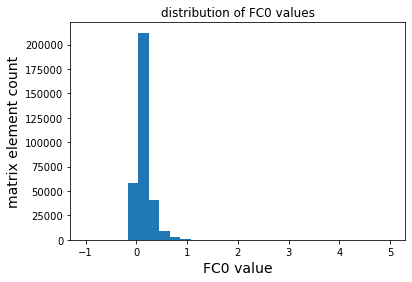

In [4]:
# Show distibution of FC0 values.
plt.figure()
plt.hist(FC_emp[:, :, _I_NO_TIMESHIFT, :, :].flatten(),
         bins=np.linspace(-1, 5, 30))
plt.xlabel('FC0 value', fontsize=14)
plt.ylabel('matrix element count', fontsize=14)
plt.title('distribution of FC0 values')
plt.show()

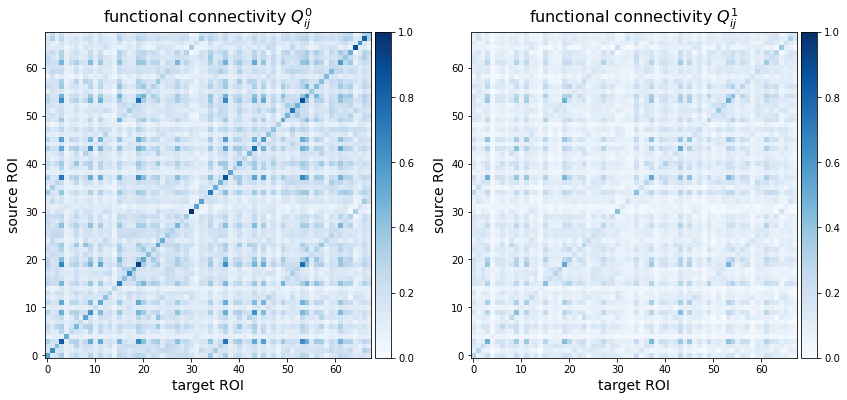

In [5]:
# Show FC0 averaged over subjects for the rest run.
plt.figure(figsize=(14, 6))
plt.subplot(121)
FC_avg_over_subj = FC_emp[:, _I_REST_RUN,
                          _I_NO_TIMESHIFT, :, :].mean(axis=_SUBJECT_AXIS)
ax = plt.gca()
im = ax.imshow(FC_avg_over_subj, origin='lower', cmap='Blues', vmin=0, vmax=1)
devider = make_axes_locatable(ax)
cax = devider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(im, cax=cax)
ax.set_xlabel('target ROI', fontsize=14)
ax.set_ylabel('source ROI', fontsize=14)
ax.set_title('functional connectivity $Q_{ij}^0$', fontsize=16)
# Show FC1 averaged over subjects for the rest run.
plt.subplot(122)
FC_avg_over_subj = FC_emp[:, _I_REST_RUN,
                          _I_ONE_TIMESHIFT, :, :].mean(axis=_SUBJECT_AXIS)
ax = plt.gca()
im = ax.imshow(FC_avg_over_subj, origin='lower', cmap='Blues', vmin=0, vmax=1)
devider = make_axes_locatable(ax)
cax = devider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(im, cax=cax)
ax.set_xlabel('target ROI', fontsize=14)
ax.set_ylabel('source ROI', fontsize=14)
ax.set_title('functional connectivity $Q_{ij}^1$', fontsize=16)
plt.show()

Original FC-matrixes from the Senden-paper (FIGURE 2e)


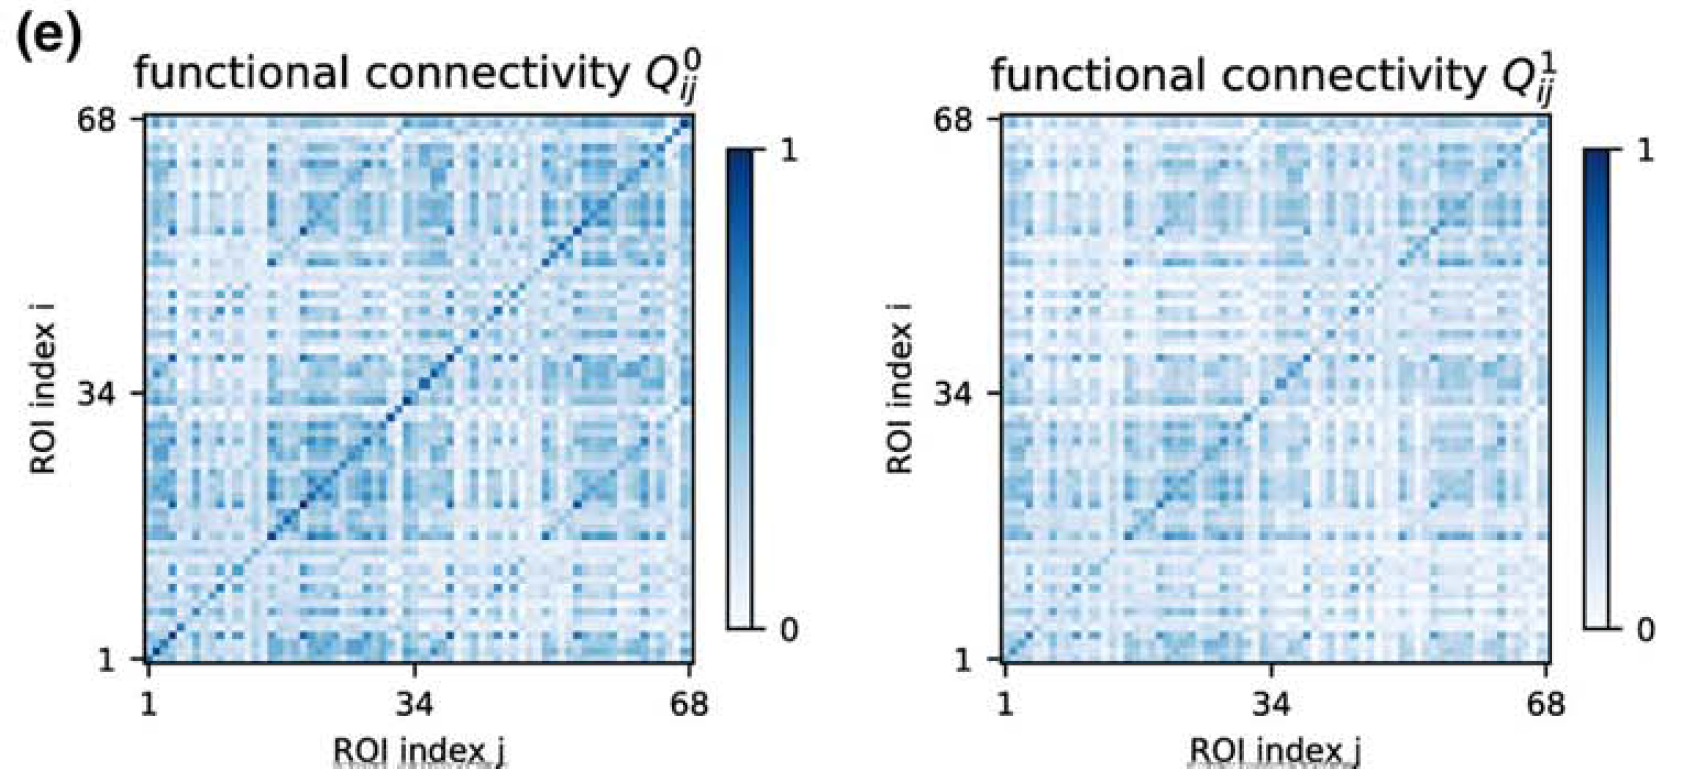

In [16]:
# Display the FC-matixes from the Senden-paper (cf. FIGURE 2e))
from IPython.display import Image
print('Original FC-matrixes from the Senden-paper (FIGURE 2e)')
Image(filename = "images_from_paper/figure2e_FC_matrixes.png", width=1000, height=1000)

### 3.1) Kommentare bzgl. der Berechnung der FC
<a id='FC_calculation'></a>

Wie in Abschnitt 2.1 "Whole-cortex dynamic model to fit empirical
BOLD covariances" geschildert, werden die Zeitserien zunächst für jeden Durchlauf (also für jeden Teilnehmer und Durchlauf) einzeln null-zentriert. Anschließend werden gemäß Gleichung (1) aus dem Senden-Paper die Kovarianzen bestimmt. Die Kovarianzen werden für verschiedene Zeitverschiebungen der Zeitserien gegeneinander berechnet. Es liegt nach Umsetzung besagter Gleichung jeweils für jeden Teilnehmer und jeden Durchlauf eine FC-Matrix vor. Bevor die Matritzen graphisch dargestellt werden, wird über die Teilnehmer gemittelt und abschließend normiert bzw. skaliert. Die Skalierung bzw. Normierung auf den in den Plots gezeigten Bereich der Colorbar [0 - 1] erfolgt vermutlich lediglich zum Zweck der graphischen Veranschaulichung, da an keiner Stelle in dem Paper derartige Schritte erwähnt werden. 
Es ist also:
- __Input__: Null-zentrierte fertig vorprozessierte fMRT-Daten (s. Abschitt 2.3 "Functional MRI data": "Finally, empirical lag FC matrices for each participant were given by the covariances of the z-normalized BOLD time series according to Equation (1)") (downloadbar unter: https://datadryad.org/stash/dataset/doi:10.5061/dryad.mc7pd)
- __Output__: Eine über die Teilnehmer gemittelte FC-Matrix (Dim.: AnzahlDerRegionen x AnzahlDerRegionen) pro Durchlauf und Zeitverschiebung der Zeitserien gegeneinander (FC hier repräsentiert durch die Kovarianzen)

Die Art der Berechnung mithilfe der Numpy-Methode *tensordot()* ist dem [MOUEC-Estimation notebook by Gilson et al. (2019)](#references) entnommen. Sie ist mehrfach unter anderem durch eine Implementierung der Kovarianzberechnung mithilfe der von der Funktionsweise her für mich leichter verständlichen *einsum()*-Methode auf Korrektheit überprüft.

### 3.2) Kommentare bzgl. der FC-Graphiken
<a id='comments_on_FC_plots'></a>
<!--![FC-Matrizen aus dem Paper zum direkten Vergleich](images_from_paper/figure2e_FC_matrixes.png)
Die hier dargestellten FC-Matrizen sind dem Senden-Paper entnommen (vgl. FIGURE 2 e)).
Schon an dieser Stelle weichen die selbst erstellten Graphiken von den Originalen ab.-->

Folgende Dinge sind bemerkenswert (Die Version aus dem Senden-Paper ist direkt vor [Abschnitt 3.1](#FC_calculation) abgebildet):
 - in dem groben Muster stimmen die Graphiken überein. (Die Plots aus diesem Notebook ähneln aber eher denen aus Fif. 7) des Vorläufer-Papers (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4794215/#pcbi.1004762.e039))
 - es handelt sich bei der Paper-Version um nicht-pdf-Formate, sodass die Matrizen "unscharf"  sind (einzelne Pixel nicht immer erkennbar)
 - in der Paper-Version sind die FC-Werte wegen dunklerer Blautöne anscheinend größer
 - die Colormaps sind vermutlich dieselben 
 - es handelt sich eindeutig um Daten, die auf den Bereich [0-1] normiert dargestellt sind - die Art und Weise, wie die Daten in den Bereich transformiert wurden, ist nicht angegeben
 
Es scheint also wie folgt zu sein:
 - __Input__: Auf den Bereich [0 - 1] normierte Kovarianzen (skaliert und geklippt oder transformiert (z.B. mit MinMaxScaler)), deren Berechnung in dem vorherigen Abschnitt dieses Notebooks (3.2 "Kommentare bzgl. der Berechnung der FC") beschrieben ist.
 - __Output__: Graphische Darstellung der normierten Kovarianzen mit der Dimension (AnzahlDerRegionen x AnzahlDerRegionen)
 
Es ergeben sich einige Fragen:
 1. Wie wurde normiert und wurden die Daten geklippt?
 2. Bedeutet der graphische Unterschied wirklich, dass die dargestellten Daten sich unterscheiden?
 3. Handelt es sich um dieselbe Colormap?
 4. Handelt es sich bei den im Paper dargestellten Matrizen um über sämtliche Teilnehmer gemittelte Versionen?

Die ersten drei Fragen sind mit den Angaben im Paper (meiner Meinung nach) nicht endgültig zu klären. Bis jetzt näher untersucht wurde:
- zur 4. Frage: In Abschnitt 2.3 "Functional MRI data" wird gesagt "Model fitting and all analyses were performed using group average lag FC matrices", sodass davon auszugehen ist, dass es sich tatsächlich um gemittelte Versionen handelt
- der Einfluss der gewählten Anzahl an untersuchten Zeit-Shifts "n_shifts" ist in Bezug auf die Graphiken (und auch in Beszug auf die sich ergebenden FC-Werte) sehr gering
- auch eine durch eine entsprechende Skalierung der FC-Werte hervorgerufene "Farb-Intensivierung" der Plots führt nicht dazu, dass sich die Graphiken bedeutend ähnlicher sehen (die weniger stark gefärbten mehrere Pixel breiten Streifen treten nicht so deutlich wie in dem Senden-Paper hervor )

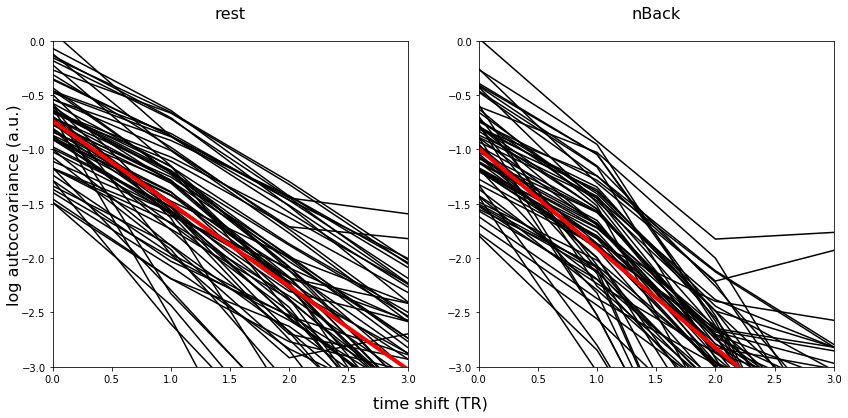

In [7]:
# Calculate the logarithm of the autocovariance. 
ac = FC_emp.diagonal(axis1=3, axis2=4)
log_ac = np.log(np.maximum(ac[:, :, :, :].mean(axis=_SUBJECT_AXIS), 1e-2))
v_tau = np.arange(ac.shape[2], dtype=np.float)
# Show the autocovariance for the rest run.
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
fig.text(0.5, 0.03, 'time shift (TR)', ha='center', fontsize=16)
fig.text(0.08, 0.5, 'log autocovariance (a.u.)', va='center', 
         rotation='vertical', fontsize=16)
plt.subplot(121)
plt.plot(range(n_shifts), log_ac[_I_REST_RUN,:,:], '-k')
lin_reg_rest = np.polyfit( np.repeat(v_tau, n_rois), 
                          log_ac[_I_REST_RUN,:,:].reshape(-1), 1 )
plt.plot(v_tau, lin_reg_rest[0]*v_tau + lin_reg_rest[1], '-r', linewidth=4)
plt.title('rest', fontsize=16, y=1.05)
plt.ylim((-3, 0))
plt.xlim((0, 3))
# Show the autocovariance for the nBack run.
plt.subplot(122)
plt.plot(range(n_shifts), log_ac[_I_NBACK_RUN,:,:], '-k')
lin_reg_nback = np.polyfit(np.repeat(v_tau, n_rois), 
                           log_ac[_I_NBACK_RUN,:,:].reshape(-1), 1 )
plt.plot(v_tau, lin_reg_nback[0]*v_tau + lin_reg_nback[1], '-r', linewidth=4)
plt.title('nBack', fontsize=16, y=1.05)
plt.ylim((-3, 0))
plt.xlim((0, 3))
plt.show()

Original plots of the logarithm of the autocovariances from the Senden-paper (FIGURE 2b)


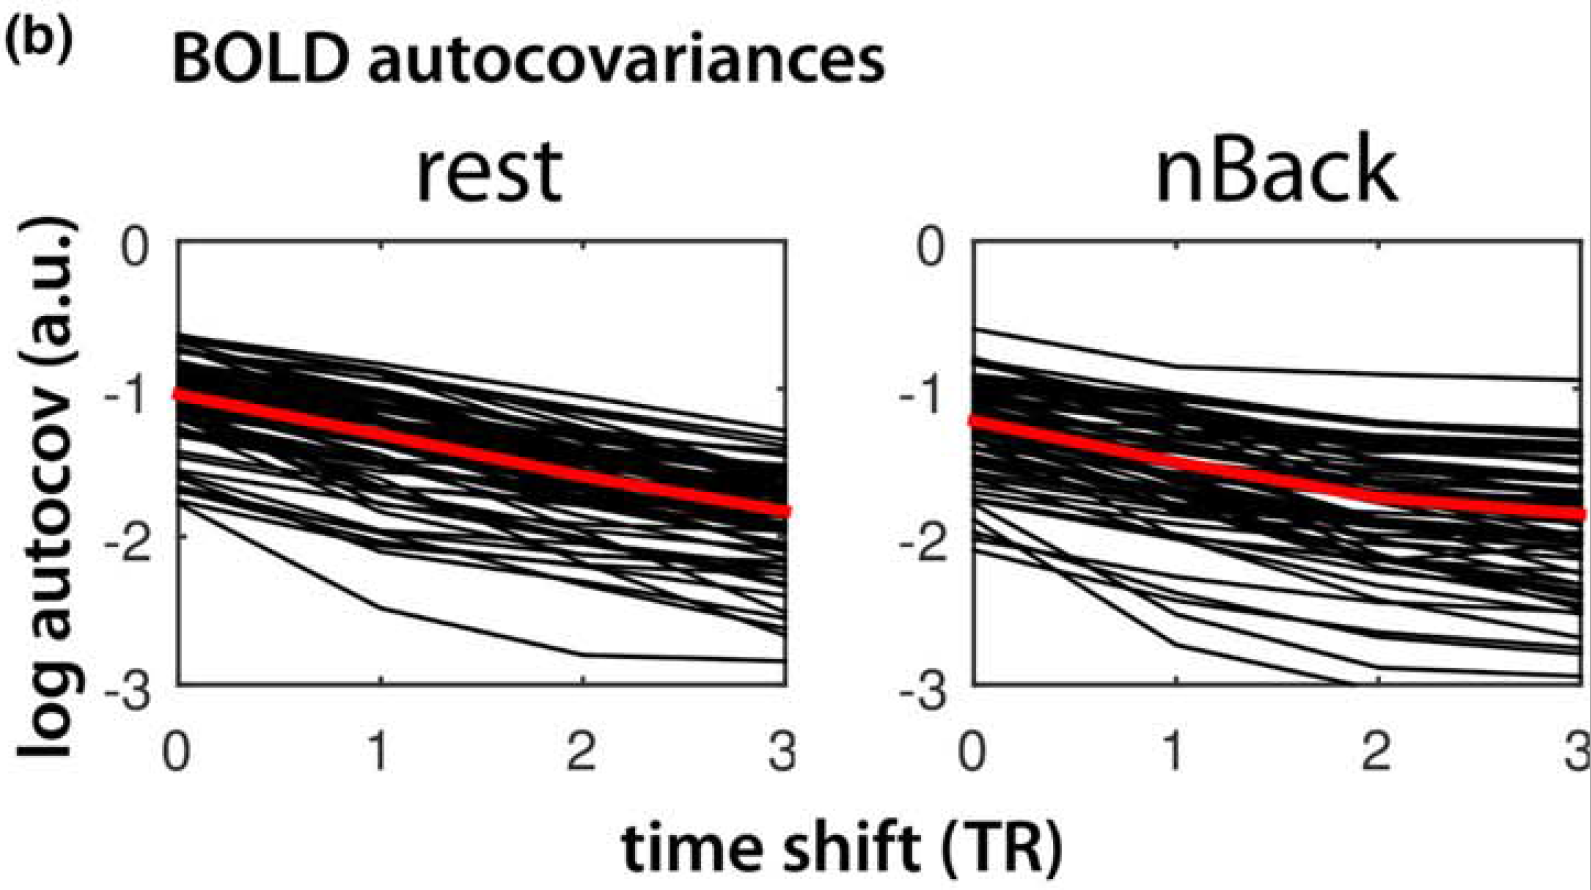

In [17]:
# Display the logarithm of the autocovariances from the Senden-paper (cf. FIGURE 2b))
from IPython.display import Image
print('Original plots of the logarithm of the autocovariances from the \
Senden-paper (FIGURE 2b)')
Image(filename = "images_from_paper/figure2b.png", width=1000, height=1000)

### 3.3) Kommentare bzgl. der Autokovarianzen und ihrer logarithmischen graphischen Darstellung
<a id='comments_on_autocovariances'></a>

Die Autokovarianzen sind in der FC-Matrix enthalten (auf der Diagonalen), da hier die FC durch die Kovarianz repräsentiert wird (vgl. Abschnitt 2.2 "Estimation procedure for EC and local excitability": "$\text{the empirical FC }\hat{Q}^0\text{ and }\hat{Q}^1$").

Welche Basis bei der logarithmischen Darstellung der Autocovarianz (FIGURE 2b) "BOLD autocovariances") gewählt wurde, ist unklar, weshalb zunächst der natürliche Logarithmus angenommen wird.
Es ist also:
- __Input__: Logarithmus der Diagonaleinträge des Durchschnittes der FC-Matrizen (Mittelung über aller Teilnehmer und Durchläufe)
- __Output__: Der Durchschnitt der Autocovarianzen (jede Region einzeln durch eine Linie dargestellt) logarithmisch aufgetragen gegen die Zahl der Zeitverschiebungen bei der Berechnung der Kovarianz

Zu bemerken ist:
- Die Verläufe der in diesem Notebook berechneten Autokovarianzen weichen sowohl bei dem rest- als auch bei dem nBack-Durchlauf eindeutig von denen in dem Paper dargestellten ab.
- Ein "Klippen" scheint in dem Senden-Paper nicht notwendig gewesen zu sein, da der Logarithmus der Autokovarianzen (mit einer Ausnahme bei dem nBack-Plot) die -3 nicht unterschreiten. Mit "Klippen" ist an dieser Stelle die Beschränkung der Werte nach unten durch die *maximum()*-Methode des Numpy-Paketes, wie in dem [MOUEC-Estimation notebook by Gilson et al. (2019)](#references) im Abschnitt "Functional connectivity" durchgeführt ("Schutz" vor zu geringen Werten im Bereich von Null als Input der Logarithmus-Funktion), gemeint. In diesem Notebook ist das Klippen allerdings notwendig.

An dieser Stelle ist also __eindeutig__ ein signifikanter Unterschied zu erkennen:
- bspw. zeigt die oberste Linie in dem Plot zum nBack-Durchlauf eindeutig nicht denselben Verlauf wie die das Äquivalent aus dem Senden-Paper#

Was allerdings nicht eindeutig geklärt ist, ist:
- Lässt sich der Unterschied zwischen Grafiken durch eine unterschiedliche Darstellungsweise erklären? Stimmen also die Daten hinter den Plots doch überein?
 - Wie auch immer die Darstellungsweise gewählt wird, es ist zu vermuten, dass z.B. der oben beschriebene signifikante Unterschied nicht durch unterschiedliche Plot-Einstellungen erklärbar ist.
- Falls bereits an dieser Stelle ein Fehler vorliegt. Wodurch kann er entstanden sein?
 - Schließt man also aus, dass der Unterschied allein durch die grafische Darstellungsweise hervorgerufen ist, so bleiben folgende Fehlerquellen:
   - fehlerhafte Berechnung der Kovarianz
       - unwahrscheinlich, weil die Implementierung mehrfach auf Korrektheit überprüft wurden (siehe [Abschnitt 3.1](#FC_calculation))
   - Plot der Daten eines einzelnen Teilnehmers
       - unwahrscheinlich, weil am Ende des Abschnittes 2.3 "Functional MRI data" gesagt wird, dass sämtliche Analysen an den gemittelten Daten durchgeführt wurden und die Graphen aller 14 Teilnehmer untersucht wurden
An dieser Stelle hängt der Debug-Prozess aktuell!!

## 4) Structural connectivity (SC)
<a id='SC'></a>

The SC-matrix can be found at http://dutchconnectomelab.nl/ under the title 'Group-averaged binary connectivity matrix based on 50 healthy subjects. Data as used in the paper "Edge-centric perspective on the human connectome: link communities in the brain", De Reus et al. 2014, Philosophical Transactions of the Royal Society B. Oct 5;369(1653).' in the download section. Although this matrix is not the one used in the paper, it looks like the best alternative, for the paper does not provide a reference to the original matrix.

Typically, structural connectivity indicates 'the probability or the density of white-matter projections between pairs of ROIs in the parcellation. The algorithm that fits the model to the functional data (BOLD signals) only uses the information about whether there is a connection or not between two ROIs, to decide whether the corresponding weight is optimized.' ([MOUEC-Estimation notebook by Gilson et al. (2019)](#references)) So, the downloaded binary matrix is completely sufficient for the purpose of reproducing the results from the abovementioned [Senden et al. (2017)](#references) paper.

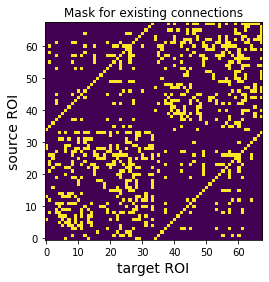

In [9]:
## Include structural connectivity.
# Load the binary structural connectivity matrix.
mask_EC = np.array(scipy.io.loadmat('BOLD_data_and_SC_matrix/BINARY_EC_MASK.mat')
                   ['grouped_umcu50_60percent'], dtype=bool)
# Enforce hermispheric connections.
for i in range(int(n_rois/2)):
    mask_EC[i, int(n_rois/2)+i] = True
    mask_EC[int(n_rois/2)+i, i] = True
# Visualise the binary structural connectivity mask.
plt.figure()
plt.imshow(mask_EC, origin='lower')
plt.xlabel('target ROI', fontsize=14)
plt.ylabel('source ROI', fontsize=14)
plt.title('Mask for existing connections', fontsize=12)
plt.show()

Original plot from the Senden-paper (FIGURE 2e) displaying the EC-matrix 


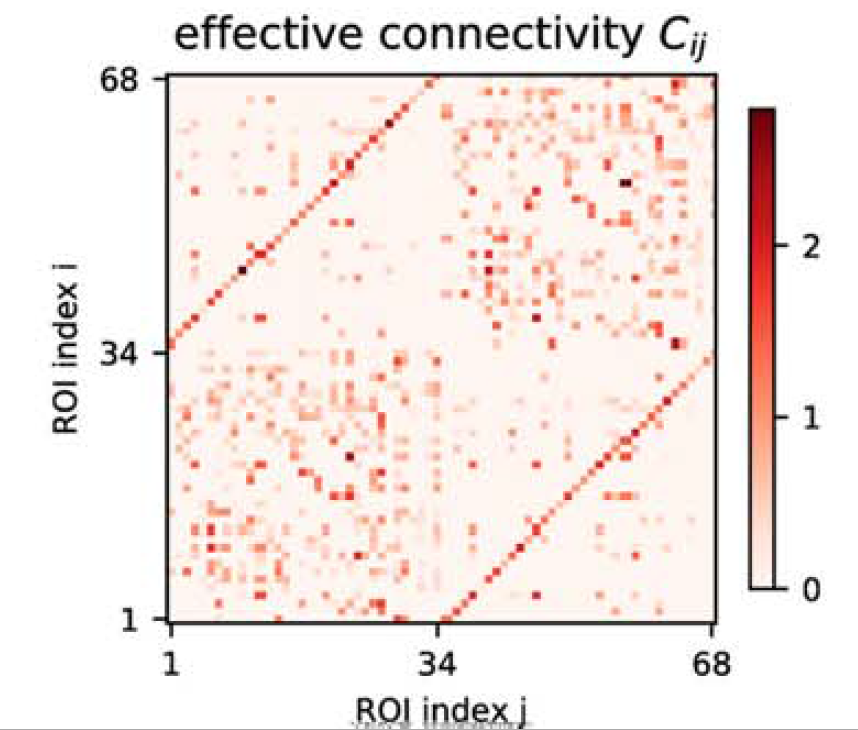

In [18]:
# Display the EC-matrix from the Senden-paper (FIGURE 2e))
from IPython.display import Image
print('Original plot from the Senden-paper (FIGURE 2e) displaying \
the EC-matrix ')
Image(filename = "images_from_paper/figure2e_EC_matrix.png", width=300, height=300)

### 4.1) Kommentare bzgl. der SC
<a id='comments_on_SC'></a>

Weil die EC-Matrix (oder auch C-Matrix) durch die strukturelle-Konnektivitäts-Matrix (SC-Matrix) maskiert wird, können anhand der oben abgebildeten EC-Matrix Rückschlüsse auf die zugrundeliegende SC geschlossen werden. Es ist eindeutig, dass die für dieses Notebook gewählte SC-Matrix nicht genau dieselbe ist, die in dem Senden-Paper verwendet wurde. Denn:
- Die Beschreibung der hier verwendeten Matrix gibt an, dass sie aus Daten von 50 Personen ermittelt wurde (siehe Name der Verlinkung im obigen [Abschnitt 4](#SC)), während in Abschnitt 2.2 unter dem Punkt Structural connectivity ausgeführt ist, dass mit Daten von 215 Teilnehmern des Human Connectome Projektes gearbeitet wurde.
- EC-Matrix: Das linke der beiden linken, leicht rot gefärbten, nah beieinander liegenden, obersten Pixel in der 4. Zeile von oben ist in der SC-Matrix gar nicht gelb eingefärbt, sodass die hier verwendete SC-Matrix nicht als Maske gedient haben kann.

Die Unteschiede zwischen den Masken sind allerdings gering. Und auch mit der nicht originalen Matrix sollte der Effekt, auf den das Paper hinaus will (deutlicher Abfall des Input/Output-Verhältnisses des Rich-Clubs bei dem Wechsel von Ruhezustand zu Aufgabenbewältigung von ca. 2 auf ca. 1) erkennbar sein.

Die Reihenfolge der Labels wurde überprüft (per Matlab-Skript) und stimmt mit der aus TABLE 1 "Cortical regions" aus dem Senden-Paper überein.

### 5) MOU-EC estimation
<a id='EC_estimation'></a>

'The optimization procedure tunes the parameters of the MOU model, namely the directional connectivity ($C$, referred to as MOU-EC) and the input covariance ($\Sigma$). It is a gradient descent that aims to minimize the matrix distance between the model and empirical covariances (referred to as spatiotemporal FC). In practice, it is encapsulated in the *fit* method of the *MOU* class. For a tutorial of the use of the MOU class for simulation and estimation, check the [*MOU_Simulation_Estimation* notebook](#references).

The optimization algorithm works with learning rates for the connectivity and the input covariance ($\epsilon_C$ and $\epsilon_\Sigma$). If they are too fast, the fitting procedure may end up being stuck in a worse local minimum than what is achievable with smaller learning rates.' ([MOUEC-Estimation notebook by Gilson et al. (2019)](#references)) In the paper (ct. [Senden et al. (2017)](#references)) $\epsilon_C = 0.001$ and $\epsilon_\Sigma = 0.1$ were chosen. For quicker but less finely graduated otimization try $\epsilon_C = 0.001$ and $\epsilon_\Sigma = 0.1$ with `mou_model.fit(filtered_ts_emp[i_sub,i_run,:,:].T, mask_C=mask_EC, mask_Sigma=mask_Sigma, epsilon_C=0.001, epsilon_Sigma=0.1)`.

All parameters/restrictions not explicitly passed to the fit@MOU method, have the correct defaults in fit_LO@MOU.

Depending on the value of $\epsilon_C$ the following cell might take about 30 minutes ($\epsilon_C = 0.0001) and more to run through.

In [11]:
## Calculate EC-matrix.
# Construct diagonal mask for input noise matrix
# (here, no input cross-correlation).
mask_Sigma = np.eye(n_rois, dtype=bool)

# Run the model optimization.
# Initialize the source arrays.
# Jacobian (off-diagonal elements = EC)
J_mod = np.zeros([n_subjects, n_runs, n_rois, n_rois])
# Local variance (input covariance matrix, chosen to be diagonal)
Sigma_mod = np.zeros([n_subjects, n_runs, n_rois, n_rois])
# Model error
dist_mod = np.zeros([n_subjects, n_runs])
# Approximation of variance about the fitted data (FC covariance matrices)
R2_mod = np.zeros([n_subjects, n_runs])
# Between-region EC matrix
C_mod = np.zeros([n_subjects, n_runs, n_rois, n_rois])

mou_model = MOU()

for i_subject in range(n_subjects):
    for i_run in range(n_runs):
        # Run the estimation of model parameters, for all sessions.
        mou_model.fit(filtered_ts_emp[i_subject, i_run, :, :].T,
                      mask_Sigma=mask_Sigma, mask_C=mask_EC)
        # Organize the optimization results into arrays.
        # Extract Jacobian of the model.
        J_mod[i_subject, i_run, :, :] = mou_model.J
        # Extract noise (auto-)covariance matrix.
        Sigma_mod[i_subject, i_run, :, :] = mou_model.Sigma
        # Extract the matrix distance between the empirical objective
        # covariances and their model counterparts
        # (normalized for each objective matrix).
        dist_mod[i_subject, i_run] = mou_model.d_fit['distance']
        # The squared Pearson correlation is taken as an approximation
        # of the variance.
        R2_mod[i_subject, i_run] = mou_model.d_fit['correlation']**2
        # The between-region EC matrix of the model
        C_mod[i_subject, i_run, :, :] = mou_model.get_C()

        print('sub / run:', i_subject, i_run, ';\t model error, R2:',
              dist_mod[i_subject, i_run], R2_mod[i_subject, i_run])
        # Store the results in files.
np.save(_RES_DIR + 'FC_emp.npy',
        FC_emp)  # Empirical spatiotemporal FC
np.save(_RES_DIR + 'mask_EC.npy',
        mask_EC)  # Mask of optimized connections
np.save(_RES_DIR + 'mask_Sigma.npy',
        mask_Sigma)  # Mask of optimized Sigma elements
np.save(_RES_DIR + 'Sigma_mod.npy',
        Sigma_mod)  # Estimated Sigma matrices
np.save(_RES_DIR + 'dist_mod.npy',
        dist_mod)  # Model error
np.save(_RES_DIR + 'J_mod.npy',
        J_mod)  # Estimated Jacobian, EC + inverse time const. on diag.
print('\nFinished.')

sub / run: 0 0 ;	 model error, R2: 0.6613649951131519 0.5354706026787119
sub / run: 0 1 ;	 model error, R2: 0.6257431867736658 0.5213176961034771
sub / run: 0 2 ;	 model error, R2: 0.775534429052557 0.35561978626290053
sub / run: 0 3 ;	 model error, R2: 0.6311827720633116 0.5674853187241146
sub / run: 0 4 ;	 model error, R2: 0.6437573992751027 0.40164773406630633
sub / run: 1 0 ;	 model error, R2: 0.6478738269076777 0.4341833691083521
sub / run: 1 1 ;	 model error, R2: 0.6282468900653158 0.4678890853183252
sub / run: 1 2 ;	 model error, R2: 0.5887257041922025 0.6076042672051662
sub / run: 1 3 ;	 model error, R2: 0.6183220398096471 0.5336571532677988
sub / run: 1 4 ;	 model error, R2: 0.6410602075420702 0.5047799677449195
sub / run: 2 0 ;	 model error, R2: 0.7329259696266047 0.4499387781239495
sub / run: 2 1 ;	 model error, R2: 0.6918668886385648 0.4502244377648983
sub / run: 2 2 ;	 model error, R2: 0.7111033505885838 0.5461777932577153
sub / run: 2 3 ;	 model error, R2: 0.8144373244653

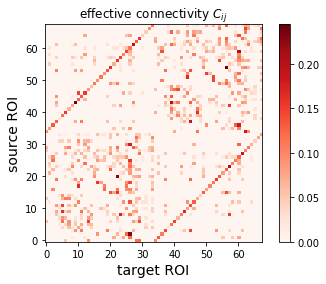

In [12]:
# Plot C-matrix for resting state data.
plt.figure()
plt.imshow(C_mod[:, _I_REST_RUN, :, :].mean(axis=_SUBJECT_AXIS),
           origin='lower', cmap='Reds')
plt.colorbar()
plt.xlabel('target ROI', fontsize=14)
plt.ylabel('source ROI', fontsize=14)
plt.title('effective connectivity $C_{ij}$')
plt.show()

Original plot from the Senden-paper (FIGURE 2e) displaying the EC-matrix 


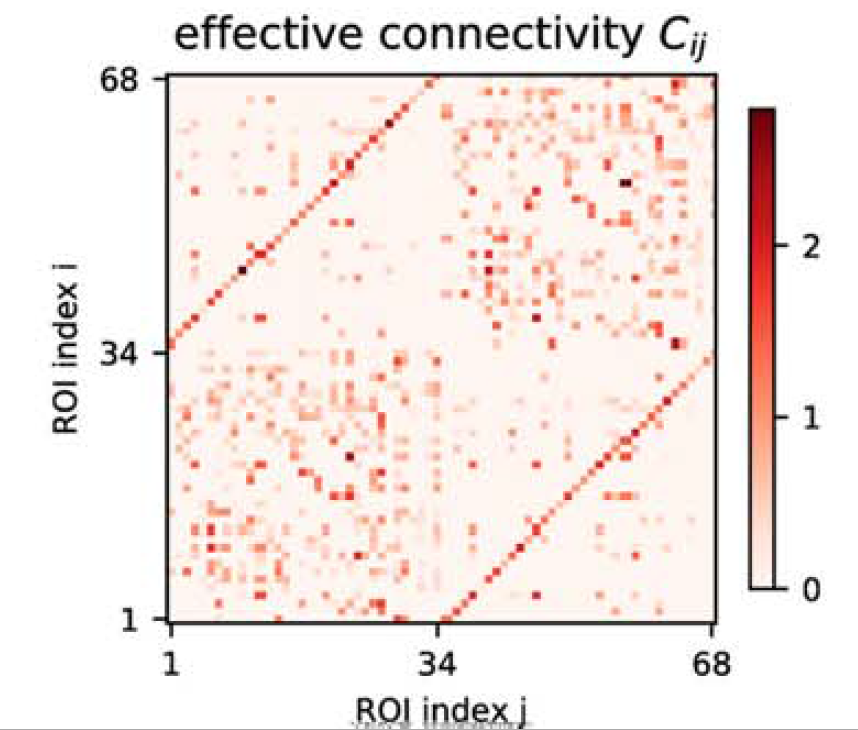

In [20]:
# Display the EC-matrix from the Senden-paper (FIGURE 2e))
from IPython.display import Image
print('Original plot from the Senden-paper (FIGURE 2e) displaying \
the EC-matrix ')
Image(filename = "images_from_paper/figure2e_EC_matrix.png", width=300, height=300)

### 5.1) Kommentare bzgl. des Optimierungsprozesses
<a id='comments_on_optimization'></a>

Vorweg muss gesagt werden, dass die Aussage "Model fitting and all
analyses were performed using group average lag FC matrices." aus dem Senden-Paper am Ende des Abschnittes 2.3 "Functional MRI data" bei der Optimierung und den darauffolgenden Analysen der lokalen Variabilität und des Input/Output-Verhältnisses noch <u>__nicht__</u> berücksichtigt wurde. D.h. das Optimierungsverfahren wurde für jeden Teilnehmer und Durchlauf einzeln durchgeführt und nicht an den über die Teilnehmer gemittelten Daten. Bis jetzt gilt bei der Optimierung also:
- __Input__: Unveränderte vorverarbeitete fMRT-Daten (pro Optimierungsdurchlauf: Daten einer Session (rest, nBack, ...) eines Teilnehmers), die in [Abschnitt 2)](#data_set) geladen und beschrieben werden.
- __Output__: Eine EC-Matrix (*J_mod* mit Nullen auf der Diagonalen) und eine $\Sigma$-Matrix (*Sigma_mod*) pro Teilnehmer und Session (und weitere für die weiteren Berechnungen nicht relevante Daten).

Zur Optimierung wird die *MOU*-Klasse aus der Datei *mou_model.py* verwendet, die die Grundlage der EC-Optimierung des Notebooks [MOUEC-Estimation notebook by Gilson et al. (2019)](#references) bildet. Die Methode *fit_LO* wurde so angepasst, dass der Prozess der Beschreibung aus Abschnitt 2.2 "Estimation procedure for EC and local excitability" des Senden-Papers entspricht. Die Änderungen betreffen ausschließlich die Methode *fit_LO()*.

Der Output wird in dem Ordner *model_parameter* gespeichert:

- Zusätzlich wird die in der *fit()*-Methode der *MOU*-Klasse erneut berechnete FC-Matrix *FC_emp* gespeichert. Weil für den Optimierungsprozell gemäß der Beschreibung in Abschnitt 2.2 "Estimation procedure for EC and local excitability" des Senden-Papers lediglich $\hat{Q}^0$ und $\hat{Q}^1$ benötigt werden, wird der Parameter "n_tau" bei dem Aufruf der *fit()*-Methode nicht übergeben, sodass der Default-Wert "n_tau=2" angenommen wird (vgl. Zeile 237 in *mou_model.py*). D.h. dass die in [Abschnitt 3](#FC) dieses Notebooks mit *n_shifts=4* berechneten FC-Werte leicht von denen abweichen, die als Grundlage der Optimierung dienen.
- Bei den beiden ebenfalls gespeicherten Matrizen *mask_EC* und *mask_Sigma* handelt es sich im ersten Fall um die schon in [Abschitt 4](#SC) näher erläuterte SC-Matrix und die Maske für die lokale Variabilität, die der Einheitsmatrix entspricht (da sie lokale Fluktuationen widerspiegelt).
- Mit dem Parameter *dist_mod* wird die Matrix-Differenz zwischen Model und den empirischen Äquivalenten als Maß der Güte der Optimierung gespeichert (für Informationen zur Berechnung siehe Abschnitt zur Berechnung von *dist_Q_hist* in *fit_LO*-Methode der *MOU*-Klasse in *mou_model.py*).

### 5.2) Kommentare bzgl. der EC-Matrix
<a id='comments_on_EC_matrix'></a>

Es ist:
- __Input__: Durch den Otimierungsprozess ermittelte EC-Matrizen pro Teilnehmer und Durchlauf.
- __Output__: Über alle Teilnehmer gemittelte EC-Matrix zum Rest-Durchlauf.

Auffällig bei dem Vergleich der beiden EC-Matrizen (Ergebnis dieses Notebooks vs. Senden-Paper) ist:
- Der von der Colourbar abgedeckte Bereich ist in diesem Notebook ca. um das 10-fache kleiner 
- Leichte strukturelle Abweichungen, da die zu Grunde liegenden SC-Matrizen unterschiedlich sind (s. [Abschnitt 4.1](#comments_on_SC)).

Untersucht:
- Eine Skalierung der der Optimierung zu Grunde liegenden fMRT-Daten (in Form einer Zeitserie) hat keinen Einfluss auf den Wertebereich, der sich für die EC-Matrix ergibt
- Durch Verkleinerung der Zeitkonstanten $\tau_x$ lässt sich der Wertebereich verändern, den die Einträge der EC-Matrix annehmen.
    - Eine fehlerhafte Berechnung der Konstanten kann dennoch nicht den Unterschied im Wertebereiches erklären, da:
        - bei zu kleinen $\tau_x$ (< 0.2) entstehehen bei den nachfolgenden Rechnungen INFs oder NANs, sodass die Optimierung scheitert (die folgende Fehlermeldung wird in der Methode *scipy.stats.pearsonr()* geschmissen, die in der Methode *fit_LO()* der Klasse *MOU* aus der Datei *mou_model()* aufgerufen wird: "ValueError: array must not contain infs or NaNs")
        - sich bei dem [MOUEC-Estimation notebook by Gilson et al. (2019)](#references) ein $\tau_x$ ergibt, welches in derselben Größenordnung liegt, wie das durch die Gleichung aus Abschnitt 2.2 "Estimation procedure for EC and local excitability" des Senden-Papers ermittelte.

 

### 6) Local variability
<a id='local_variability'></a>

As in the paper, local variability ($\Sigma$) is split up into the part exhibited by the rich club and the one exhibited by the peripheral regions.

In [14]:
## Calculate local variability for rich club and periphery.
# Create a 1D-mask for rich club regions.
mask_rc = np.zeros(n_rois, dtype=bool)
indexes_rich_club = [23, 26, 27, 57, 60, 61]
mask_rc[indexes_rich_club] = True
print('Rich club regions:\n',
      np.concatenate(roi_labels[indexes_rich_club]).tolist())

local_var = Sigma_mod[:, :, :, :].diagonal(axis1=2, axis2=3)
rc_var = local_var[:, :, mask_rc].mean(axis=0) # avarage over subjects
periph_var = local_var[:, :, ~mask_rc].mean(axis=0) # avarage over subjects
mean_rc_var = rc_var.mean(axis=1) # avarage over regions
mean_periph_var = periph_var.mean(axis=1) # avarage over regions
conf_int_rc = np.array(stt.t.interval(
    0.95, rc_var.shape[1]-1, loc=rc_var.mean(axis=1), 
    scale=stt.sem(rc_var, axis=1))).T
conf_int_periph = np.array(stt.t.interval(
    0.95, periph_var.shape[1]-1, loc=periph_var.mean(axis=1), 
    scale=stt.sem(periph_var, axis=1))).T
print('Mean of local variability (rich club):\n', run, 
      '\n', str(mean_rc_var))
print('Mean of local variability (periphery):\n', run,
      '\n', str(mean_periph_var))
print('95% confidence interval (rich club):\n', conf_int_rc)
print('95% confidence interval (periphery):\n', conf_int_periph)

Rich club regions:
 ['lh_precuneus', 'lh_superiorfrontal', 'lh_superiorparietal', 'rh_precuneus', 'rh_superiorfrontal', 'rh_superiorparietal']
Mean of local variability (rich club):
 ['Rest', 'nBack', 'Flanker', 'mRotation', 'OddManOut'] 
 [0.04162144 0.04172214 0.03924228 0.04484446 0.04086206]
Mean of local variability (periphery):
 ['Rest', 'nBack', 'Flanker', 'mRotation', 'OddManOut'] 
 [0.1490635  0.1541512  0.14432992 0.15982312 0.15312455]
95% confidence interval (rich club):
 [[0.0218512  0.06139169]
 [0.02771601 0.05572828]
 [0.02039205 0.0580925 ]
 [0.02958672 0.0601022 ]
 [0.02879221 0.05293191]]
95% confidence interval (periphery):
 [[0.12516324 0.17296376]
 [0.12738577 0.18091663]
 [0.12030654 0.1683533 ]
 [0.13333422 0.18631201]
 [0.12636727 0.17988183]]


### 6.1) Kommentare bzgl. der lokalen Variabilität
<a id='comments_on_local_variability'></a>

Wie schon zu Beginn des [Abschnittes 5.1](#comments_on_optimization) erwähnt, basieren die Ergebnisse fälschlicherweise noch nicht auf den Gruppen-gemittelten FC-Daten!

Ziel ist es, die in Abschnitt 3.2 "Local variability" des Senden-Papers angegebenen Werte zu reproduzieren.
Zurzeit gilt also:
- __Input__: Bei der Optimierung ermittelte $\Sigma$-Matrizen (eine Matrix pro Teilnehmer und Durchlauf)
- __Output__: 
    - Durchschnitt über (Teilnehmer und) Regionen:
        - 1. des Rich clubs
        - 2. der Peripherie
    - 95%-Konfidenzintervall (in Bezug auf die Streuung zwischen den Regionen und auf Grundlage der Student-t-Verteilung):
        - 1. des Rich clubs
        - 2. der Peripherie
    
Bemerkungen zur Abweichung von den Paper-Ergebnissen:
- Alle Werte sind ca. um den Faktor 10 kleiner als die Werte aus dem Senden-Paper (vmtl. ähnlicher Faktor wie bei der EC-Matrix vgl. [Abschnitt 5.2](#comments_on_EC_matrix))
- Die Werte der lokalen Variabilität sind allerdings - anders als die der EC-Matrix - abhängig von der Skalierung der BOLD-Zeitserien, die als Input des Optimierungsprozesses dienen (vgl. [Abschnitt 5.1](#comments_on_optimization)).
- Die Verhältnisse der Durchschnittswerte der unterschiedlichen Durchläufe untereinander entsprechen nicht denen aus dem Senden-Paper
    - z.B. gilt für den "mean of local variability (rich club)", dass der 4. Eintrag (mental rotation task) den größten Wert annimmt, während in dem Paper der 2. Eintrag (n-back task) am größten ist
- Das Verhältnis von Rich-club- und Peripherie-Werten ist dem in dem Senden-Paper sehr ähnlich (bei Berücksichtigung des schon erwähnten Faktors von ca. 10).
    - Hier: mean of local variability (rich club) + 0.1 ~ mean of local variability (periphery)
    - Im Senden-Paper: mean of local variability (rich club) + 1 ~ mean of local variability (periphery)

Zu untersuchen/ zu klären bleibt:
- Wie sehen die Ergebnisse mit Berücksichtigung der Mittelung der FC-Matrizen vor den Optimierung aus (vgl. [Beginn des Abschnittes 5.1](#comments_on_optimization)).
- Welche Art von Verteilung wurde bei der Berechnung der Konfidenzintervalle angenommen? Student-t-Verteilung wegen geringer Zahl an Regionen? 

### 7) Input-output ratio
<a id='io_ratio'></a>

The information flow between regions is encapsulated in the $C$-matrix. In order to test the hypotheses that the rich club might gate the input it receives from peripheral regions, the inter-rich-club-connections are ignored. This means that only the information flow from and to the rich club is examined when it comes to the inspection of the rich club input-output-ratio.

The input-output ratio of the periphery takes into account all inter-periphery activity (exclusively).

In [15]:
## Calculate the input-to-output ratio of total incoming/outgoing EC.
# Create a 2D-mask for inter rich club connections.
mask_inter_rc = np.zeros([n_rois, n_rois], dtype=bool)
rc_ind_combin = np.array(list(
    itertools.product(indexes_rich_club, repeat=2))).T
mask_inter_rc[rc_ind_combin[0], rc_ind_combin[1]] = True
# Calculate the ratio of incoming/outgoing EC from and to the rich club
no_rc_connections_C = np.copy(C_mod)
no_rc_connections_C[:, :, mask_inter_rc] = 0
roi_input = no_rc_connections_C[:, :, :, :].sum(axis=2)
roi_output = no_rc_connections_C[:, :, :, :].sum(axis=3)
io_rc = (roi_input[:, :, mask_rc].mean(axis=0) /
         roi_output[:, :, mask_rc].mean(axis=0))
# Calculate and print the mean io-ratio and the CI for rich club regions
mean_rc_io = io_rc[:, :].mean(axis=1)
conf_int_rc = np.array(stt.t.interval(
    0.95, io_rc.shape[1]-1, loc=io_rc.mean(axis=1), 
    scale=stt.sem(io_rc, axis=1))).T
print('Mean input-to-output ratio of the rich club:\n', run,
      '\n', str(mean_rc_io))
print('95% confidence interval (rich club):\n', str(conf_int_rc))

# Create a 2D-mask for inter periphery connections.
mask_inter_periph = np.zeros([n_rois, n_rois], dtype=bool)
periph_ind_combin = np.array(list(itertools.product(list(
    x for x in range(68) if x not in indexes_rich_club), repeat=2))).T
mask_inter_periph[periph_ind_combin[0], periph_ind_combin[1]] = True
# Calculate the ratio of incoming/outgoing EC among peripheral regions 
only_periph_connections_C = np.copy(C_mod)
only_periph_connections_C[:, :, ~mask_inter_periph] = 0
roi_input = only_periph_connections_C[:, :, :, :].sum(axis=2)
roi_output = only_periph_connections_C[:, :, :, :].sum(axis=3)
io_periph = (roi_input[:, :, ~mask_rc].mean(axis=0) /
         roi_output[:, :, ~mask_rc].mean(axis=0))
# Calculate and print the mean io-ratio and the CI for peripheral regions
mean_periph_io = io_periph[:, :].mean(axis=1)
conf_int_periph = np.array(stt.t.interval(
    0.95, io_periph.shape[1]-1, loc=io_periph.mean(axis=1), 
    scale=stt.sem(io_periph, axis=1))).T
print('Mean input-to-output ratio of the priphery:\n', run,
      '\n', str(mean_periph_io))
print('95% confidence interval (priphery):\n', str(conf_int_periph))

# plt.figure()
# plt.imshow(mask_inter_rc, origin='lower')
# plt.xlabel('target ROI', fontsize=14)
# plt.ylabel('source ROI', fontsize=14)
# plt.title('Mask for inter rc connections', fontsize=12)
# plt.show()
# 
# plt.figure()
# plt.imshow(mask_inter_periph, origin='lower')
# plt.xlabel('target ROI', fontsize=14)
# plt.ylabel('source ROI', fontsize=14)
# plt.title('Mask for inter periphery connections', fontsize=12)
# plt.show()

Mean input-to-output ratio of the rich club:
 ['Rest', 'nBack', 'Flanker', 'mRotation', 'OddManOut'] 
 [1.48495694 1.88671523 1.56186645 1.64396907 1.66005386]
95% confidence interval (rich club):
 [[0.72316304 2.24675083]
 [1.09763718 2.67579327]
 [0.7003348  2.4233981 ]
 [0.81726144 2.4706767 ]
 [0.93711842 2.3829893 ]]
Mean input-to-output ratio of the priphery:
 ['Rest', 'nBack', 'Flanker', 'mRotation', 'OddManOut'] 
 [0.99285896 1.01499667 1.01237532 1.02449427 1.00399315]
95% confidence interval (priphery):
 [[0.90373501 1.08198291]
 [0.90618691 1.12380642]
 [0.90971716 1.11503347]
 [0.91160185 1.13738669]
 [0.89968467 1.10830163]]


### 7.1) Kommentare bzgl. des Input-Output-Verhältnisses
<a id='comments_on_io_ratio'></a>

Auch hier gilt: Wie schon zu Beginn des [Abschnittes 5.1](#comments_on_optimization) erwähnt, basieren die Ergebnisse fälschlicherweise noch nicht auf den Gruppen-gemittelten FC-Daten!

Ziel ist es, die in Abschnitt 3.3 "Input–output ratio" des Senden-Papers angegebenen Werte zu reproduzieren.
Zurzeit gilt also:
- __Input__: Bei der Optimierung ermittelte EC-Matrizen bzw. C-Matrizen (eine Matrix pro Teilnehmer und Durchlauf)
- __Output__:
    - Durchschnitt über (Teilnehmer und) Regionen:
        - 1. des Rich clubs
        - 2. der Peripherie
    - 95%-Konfidenzintervall (in Bezug auf die Streuung zwischen den Regionen und auf Grundlage der Student-t-Verteilung):
        - 1. des Rich clubs
        - 2. der Peripherie
       
Bemerkenswert ist:
- die entscheidene Aussage, dass bei dem Rest-Durchlauf das Verhältnis bei dem Rich-Club deutlich größer (ca. 2) ist als das bei task-runs (ca. 1) kann <u>nicht</u> reproduziert werden
- Zu Beginn des Abschnittes 3.3 "Input–output ratio" wird gesagt, dass "the input-to-output ratio of total incoming/outgoing EC from and to the periphery" berechnet wird, wobei diese Beschreibung vermutlich nicht eindeutig ist:
    - Handelt es sich bei "total incoming/outgoing EC" um die Summe der entsprechenden Einträge der EC-Matrix(, die in dem Senden-Paper und in diesem Notebook auch C-Matrix genannt wird)?
    
Zu untersuchen/ zu klären bleibt:
- Wie sehen die Ergebnisse mit Berücksichtigung der Mittelung der FC-Matrizen vor den Optimierung aus (vgl. [Beginn des Abschnittes 5.1](#comments_on_optimization)).
- Sollte nicht auch ohne diese Mittelung der FC-Matritzen (mit dem hier gewählten Ansatz) die entscheidende Aussage bestätigt werden können?

### 8) References
<a id='references'></a>

MOUEC-Estimation notebook by Gilson et al. (2019): Andrea Insabato, Gorka Zamora-López, Matthieu Gilson 1_MOUEC_Estimation.ipynb. 2019. https://github.com/mb-BCA/notebooks_review2019/blob/master/1_MOUEC_Estimation.ipynb

*MOU_Simulation_Estimation* notebook: Andrea Insabato, Gorka Zamora-López, Matthieu Gilson MOU_Simulation_Estimation.ipynb. 2019. https://github.com/mb-BCA/pyMOU/blob/master/examples/MOU_Simulation_Estimation.ipynb

*pyMOU* library: Andrea Insabato, Gorka Zamora-López, Matthieu Gilson. 2019. https://github.com/mb-BCA/pyMOU 

Senden et al. (2017): M. Senden, N. Reuter, M. P. van den Heuvel, R. Goebel, G. Deco, and M. Gilson. Task-related effective connectivity reveals that the cortical rich club gates cortex-wide communication. Hum Brain Mapp, 2017. https://onlinelibrary.wiley.com/doi/full/10.1002/hbm.23913